In [1]:
from ultralytics import YOLO
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
import os

C:\Users\ziadz\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YOLO('models/best.pt')

In [3]:
def get_box_mask(prediction):
    result = defaultdict(list)
    for pred in prediction[0].boxes[0].xywh[0]:
        result['boxes'].append(pred.cpu().numpy())
    result['masks'] = prediction[0].masks[0].xy[0]

    return result

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_image_with_bbox(orig_img, bbox):
    center_x, center_y, w, h = map(int, [bbox[0], bbox[1], bbox[2], bbox[3]])
    # Calculate the top-left corner of the bounding box
    x = int(center_x - w / 2)
    y = int(center_y - h / 2)
    # Ensure the crop coordinates are within the image dimensions
    x = max(0, x)
    y = max(0, y)
    w = min(orig_img.shape[1] - x, w)
    h = min(orig_img.shape[0] - y, h)

    # Crop the image
    cropped_img = orig_img[y:y+h, x:x+w]

    # Display the cropped image
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Image')
    plt.show()

    return cropped_img


In [5]:
import cv2
import numpy as np

def ensure_horizontal(image, bbox):
    center_x, center_y, w, h = bbox
    
    # Check if the ID card is vertical
    if h > w:
        # Calculate the center of rotation
        image_center = tuple(np.array(image.shape[1::-1]) / 2)

        # Rotate the image 90 degrees clockwise
        rot_mat = cv2.getRotationMatrix2D(image_center, 90, 1.0)
        rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        resized = cv2.resize(rotated_image,(rotated_image.shape[0],rotated_image.shape[1]))

        # Calculate corner points of the original bbox
        top_left = np.array([center_x - w/2, center_y - h/2])
        bottom_right = np.array([center_x + w/2, center_y + h/2])
        rect_points = np.array([top_left, bottom_right], dtype=np.float32)

        # Transform corner points
        transformed_points = cv2.transform(np.array([rect_points]), rot_mat)[0]

        # Calculate new bounding box
        x_new = (transformed_points[0][0] + transformed_points[1][0]) / 2
        y_new = (transformed_points[0][1] + transformed_points[1][1]) / 2
        w_new = np.abs(transformed_points[1][0] - transformed_points[0][0])
        h_new = np.abs(transformed_points[1][1] - transformed_points[0][1])

        return rotated_image, (x_new, y_new, w_new, h_new)

    return image, bbox

In [6]:
result = model.predict(source="images/test1.jpg",save=True,conf=0.5)


image 1/1 c:\cysheild\task\line detection\labelimg\datasets\test1.jpg: 640x384 1 card, 20.2ms
Speed: 3.0ms preprocess, 20.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs\segment\predict15


In [7]:
res = get_box_mask(result)

In [8]:
res.keys()

dict_keys(['boxes', 'masks'])

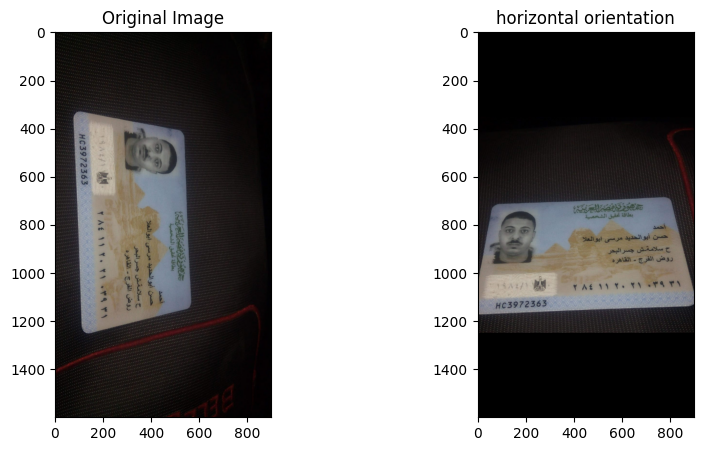

In [9]:
mask = res['masks']

x, y, w, h = [i for i in res['boxes']]
bbox = (x, y, w, h)

# Ensure the image and bbox are horizontal
horizontal_image, horizontal_mask = ensure_horizontal(result[0].orig_img, bbox=bbox)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result[0].orig_img , cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(horizontal_image, cv2.COLOR_BGR2RGB))
plt.title('horizontal orientation')



plt.show()

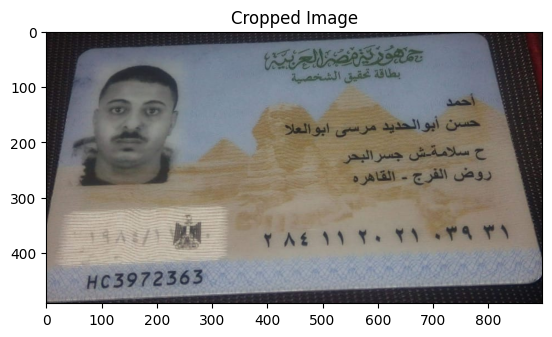

In [10]:
cropped_img = crop_image_with_bbox(bbox=horizontal_mask,orig_img=horizontal_image)

C:\Users\ziadz\AppData\Local\Temp\ipykernel_5060\3411778139.py:5: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


Skew angle: -2


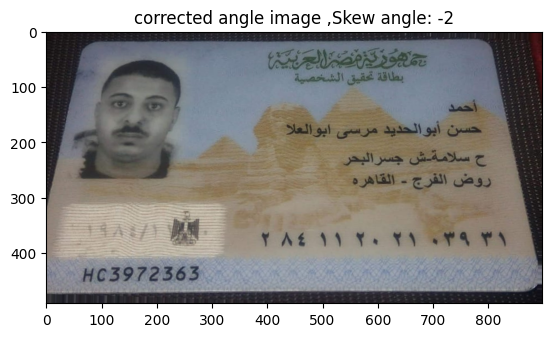

In [11]:
from scipy.ndimage import interpolation as inter

def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(image, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

if __name__ == '__main__':
    angle, corrected = correct_skew(cropped_img)
    print('Skew angle:', angle)
    plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
    plt.title(f'corrected angle image ,Skew angle: {angle}')

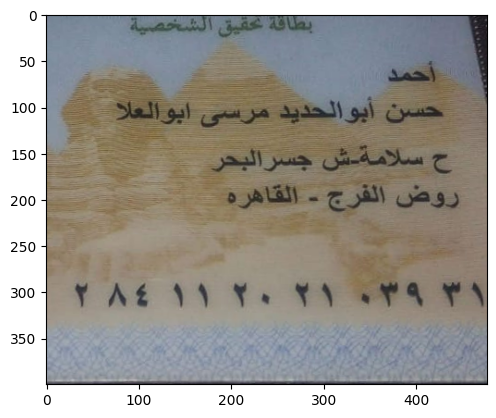

In [13]:
def crop_part_image(image):
    height, width = image.shape[:2]

    # Calculate 40% of the width and 15% of height
    width_cut = int(width * 0.40)
    height_cut = int(height*0.15)
    # Define the ROI
    crop_img = image[height_cut: int(height-int(height*0.04)), width_cut: width-int(width*0.07)]
    
    plt.imshow(cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB))
    plt.show()
    return crop_img

crop_image = crop_part_image(corrected)

line segmenation


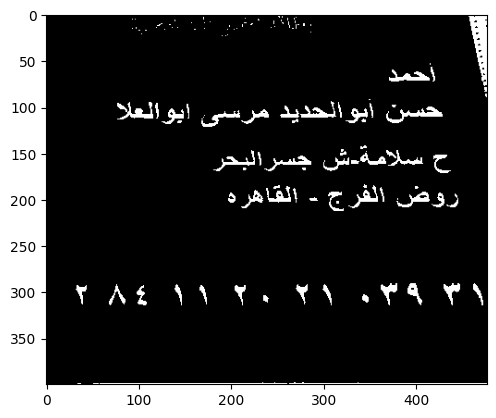

In [15]:
def thresholding(image,black):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(img_gray,black,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh
#130
thresh_img = thresholding(crop_image,70);

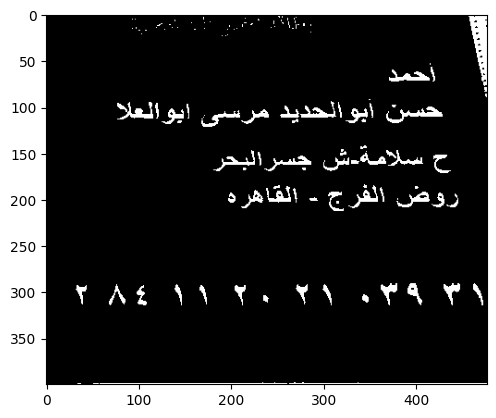

In [16]:
#dilation
def dilation(thresh_img,v1=1,v2=1):
        
    kernel = np.ones((v1,v2), np.uint8)
    #(1,2),iter=2
    dilated = cv2.dilate(thresh_img, kernel, iterations = 2)
    plt.imshow(dilated, cmap='gray');
    return dilated
dilated2 = dilation(thresh_img)

In [40]:
def creat_masks(dilated):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (130,2))
    masked = cv2.morphologyEx(dilated, cv2.MORPH_DILATE, kernel)
    plt.imshow(cv2.cvtColor(masked,cv2.COLOR_BGR2RGB))
    return masked
    

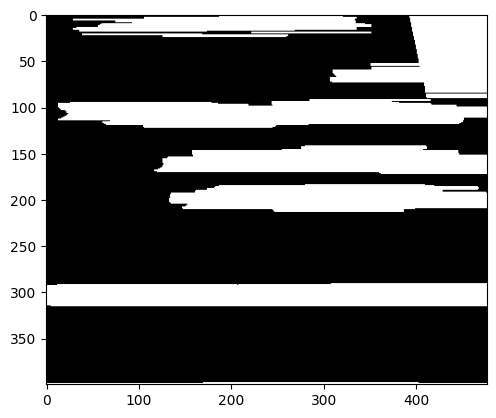

In [41]:
masked = creat_masks(thresh_img)

In [69]:
def get_segments(masked_img, img):
    bboxes = []
    segments_images = []
    contours, _ = cv2.findContours(masked_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        bboxes.append((x, y, w, h))

    for box in bboxes:
        x, y, w, h = box
        h_margin = int(h * 0.40)

        # Ensure the coordinates are within the image bounds
        y1 = max(y - h_margin, 0)
        y2 = min(y + h + h_margin, img.shape[0])

        segment = img[y1:y2, x:x+w]

        # Check if the segment is not empty
        if segment.size > 0 and (y2 - y1) > 10:
            segments_images.append(segment)
            plt.imshow(cv2.cvtColor(segment,cv2.COLOR_BGR2RGB))
            plt.show()

    return segments_images



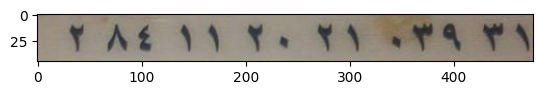

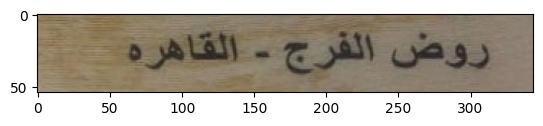

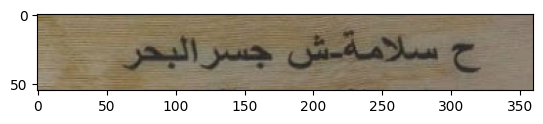

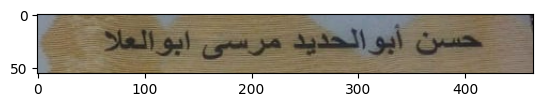

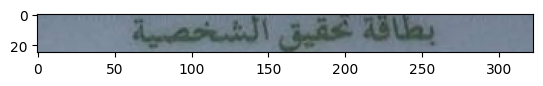

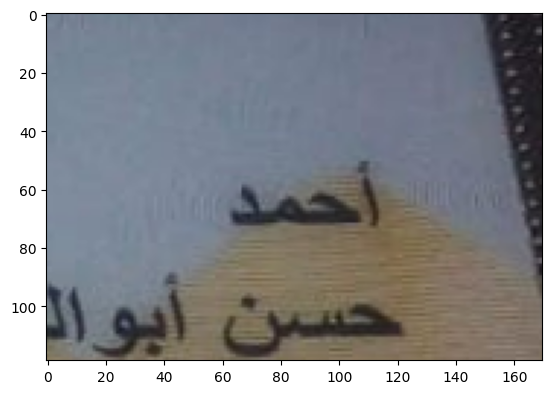

In [70]:
segments_images = get_segments(masked,crop_image)

In [ ]:
os.makedirs('samples')

In [58]:
samples_path =os.listdir('samples')

In [61]:
def samples_preprocessing(segments_images,blk):
    samples_list = []        
    for idx,seg in enumerate(segments_images):
        thresh = thresholding(seg,blk)
        dilated = dilation(thresh)
        print(f'samples/sample{idx}.jpg')
        samples_list.append(f'samples/sample{idx}.jpg')
        cv2.imwrite(f'samples/sample{idx}.jpg',dilated)
        plt.imshow(cv2.cvtColor(dilated,cv2.COLOR_BGR2RGB))
        plt.show()
    return samples_list
    

samples/sample0.jpg


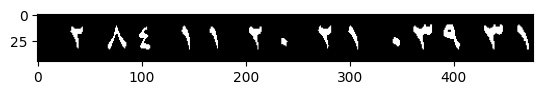

samples/sample1.jpg


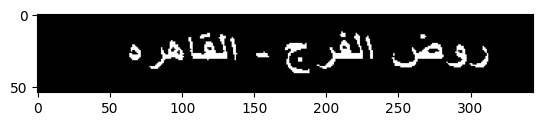

samples/sample2.jpg


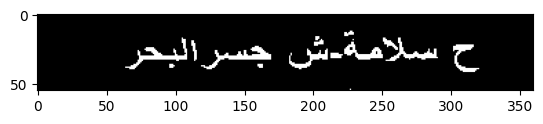

samples/sample3.jpg


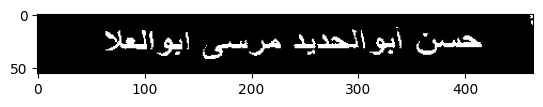

samples/sample4.jpg


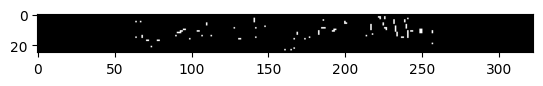

samples/sample5.jpg


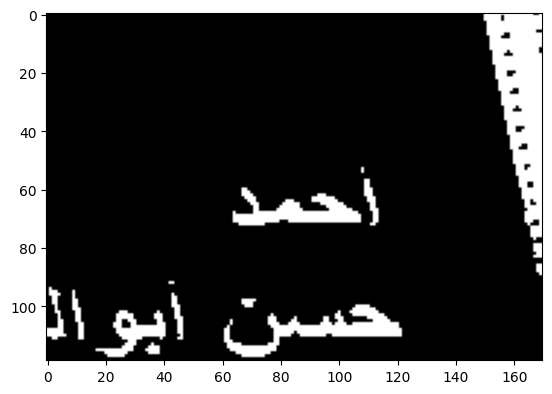

In [62]:
samples_list = samples_preprocessing(segments_images,70)

In [63]:
from ArabicOcr import arabicocr

In [64]:
samples_list

['samples/sample0.jpg',
 'samples/sample1.jpg',
 'samples/sample2.jpg',
 'samples/sample3.jpg',
 'samples/sample4.jpg',
 'samples/sample5.jpg']

In [65]:
def Extract_data_OCR(image_path,out_image,filename):
	results=arabicocr.arabic_ocr(image_path,out_image)
	print(results)
	words=[]
	for i in range(len(results)):	
			word=results[i][1]
			words.append(word)
	with open (filename,'w',encoding='utf-8')as myfile:
			myfile.write(str(words))
	
	img = cv2.imread(out_image)
	plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
	plt.show()
	plt.title('result of detection')
	return words

In [66]:
out_image='images/result.jpg'

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.6053: ٣١ ٠٣٩ ٢١ ٢٠ ١١ ٨٤ ٢
[[[[27, 5], [477, 5], [477, 42], [27, 42]], '٣١ ٠٣٩ ٢١ ٢٠ ١١ ٨٤ ٢', 0.605308742382455]]


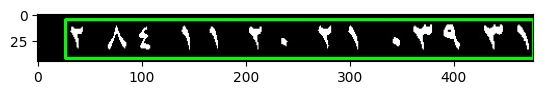

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.8885: روض الفرج
[INFO] 0.7530: القاهره
[[[[163, 4], [321, 4], [321, 48], [163, 48]], 'روض الفرج', 0.8884919475875519], [[[57.170867717450925, 15.622128032686199], [141.65475466714594, 3.6027607015021332], [145.82913228254907, 33.3778719673138], [60.345245332854056, 46.397239298497865]], 'القاهره', 0.7530144009565063]]


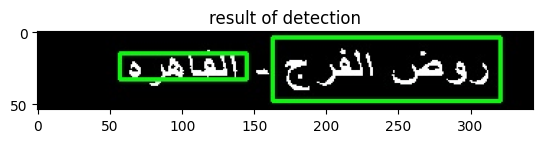

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.5604: ح سلامةءش جسرالبحر
[[[[62, 2], [328, 2], [328, 50], [62, 50]], 'ح سلامةءش جسرالبحر', 0.5604119509320775]]


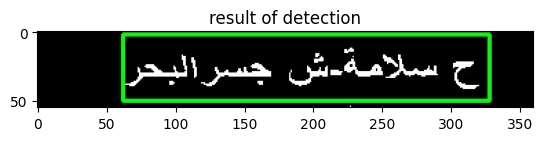

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.8273: حسن ابوالحديد مرسى ابوالعلا
[[[[59, 9], [419, 9], [419, 47], [59, 47]], 'حسن ابوالحديد مرسى ابوالعلا', 0.8273349008396979]]


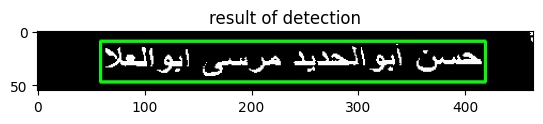

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[]


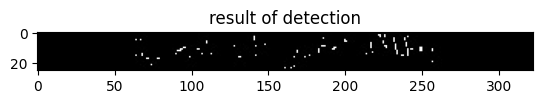

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...
[INFO] 0.9900: احمد
[INFO] 0.4665: حسن آبواا
[[[[62, 53], [119, 53], [119, 79], [62, 79]], 'احمد', 0.989954948425293], [[[0, 90], [122, 90], [122, 119], [0, 119]], 'حسن آبواا', 0.4665063387823428]]


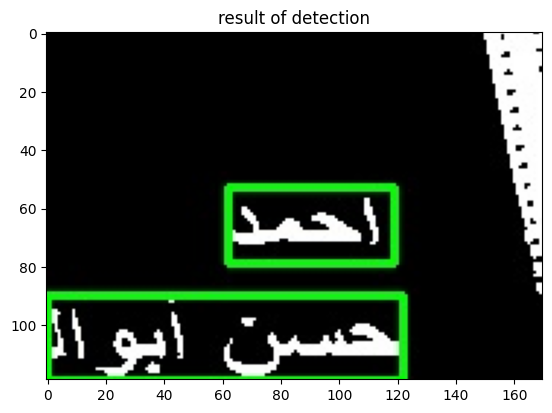

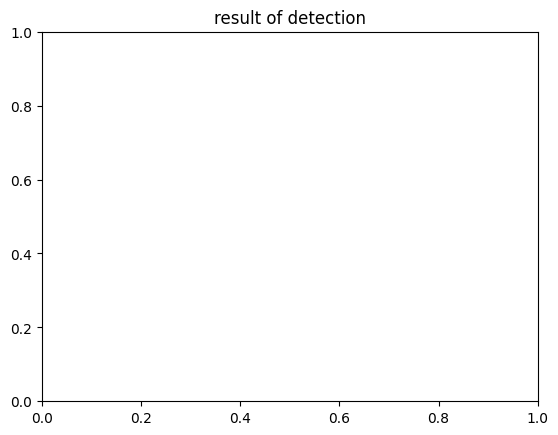

In [67]:
words = []
for sample in samples_list:
    word = Extract_data_OCR(sample,out_image,'result.txt')
    words.append(word)

In [68]:
words

[['٣١ ٠٣٩ ٢١ ٢٠ ١١ ٨٤ ٢'],
 ['روض الفرج', 'القاهره'],
 ['ح سلامةءش جسرالبحر'],
 ['حسن ابوالحديد مرسى ابوالعلا'],
 [],
 ['احمد', 'حسن آبواا']]